- which subgraphs actually touch the final layer?
- which subgraphs actually touch the final layer and contain the correct class as a node in the subgraph?
- are nearest neighbors represented as nearest neighbors in graph space?
- what are the nearest neighbors of the additional graph structure induced by the adversary?

In [1]:
import os
import parse

import torch
import torch.nn.functional as F
from torchvision import datasets, transforms
import dionysus as dion
import numpy as np
from scipy.spatial.distance import hamming, cosine
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

from pt_activation.functions.nnlayout import draw_neural_net
from pt_activation.models.cff import CFF

%load_ext autoreload
%autoreload 2

In [2]:
def get_adv_info(filename):
    format_string = 'true-{}_adv-{}_sample-{}.npy'
    parsed = parse.parse(format_string, filename)
    return {'true class':int(parsed[0]), 'adv class':int(parsed[1]), 'sample':int(parsed[2])}

def read_adversaries(loc):
    ret = []
    for f in os.listdir(loc):
        if os.path.isfile(os.path.join(loc,f)) and f.find('.npy') != -1:
            adv = np.load(os.path.join(loc, f))
            info = get_adv_info(f)
            info['adversary'] = adv
            ret.append(info)
    return ret
    

In [3]:
adv_directory_loc = '/home/tgebhart/projects/pt_activation/logdir/adversaries/mnist/carliniwagnerl2/cff_relu.pt'
adversaries = read_adversaries(adv_directory_loc)
adversaries = sorted(adversaries,  key=lambda k: k['sample'])

In [4]:
def create_filtrations(model, batch_size, up_to):
    device = torch.device("cpu")
    kwargs = {'num_workers': 1, 'pin_memory': True}
    test_loader = torch.utils.data.DataLoader(
        datasets.MNIST('../data', train=False, download=True, transform=transforms.Compose([
                           transforms.ToTensor(),
#                            transforms.Normalize((0.1307,), (0.3081,))
                       ])), batch_size=batch_size, shuffle=False, **kwargs)

    model.eval()
    test_loss = 0
    correct = 0
    t = 0
    res_df = []
    nms = []
    wms = []
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output, hiddens = model(data, hiddens=True)
            test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
            for s in range(data.shape[0]):
                # check if this makes sense
                this_hiddens = [hiddens[0][s], hiddens[1][s], hiddens[2][s]]
                print('Filtration: {}'.format(s+t))
                f, nm, wm = model.compute_dynamic_filtration2(data[s], this_hiddens, percentile=50, return_nm=True, absolute_value=True)
                row = {'filtration':f, 'loss':output.cpu().numpy()[s][0], 'class':target.cpu().numpy()[s], 'prediction':pred.cpu().numpy()[s][0]}
                res_df.append(row)
                nms.append(nm)
                wms.append(wm)

            t += batch_size
            if t >= up_to:
                break

    return pd.DataFrame(res_df), nms, wms

def create_adversary_filtrations(model, batch_size, up_to, adversaries):
    device = torch.device("cpu")
    adv_images = torch.tensor(np.array([a['adversary'] for a in adversaries]))
    adv_labels = torch.tensor(np.array([a['true class'] for a in adversaries]))
    
    print(adv_images.shape)
    
    advs = torch.utils.data.TensorDataset(adv_images, adv_labels)
    test_loader = torch.utils.data.DataLoader(advs, batch_size=batch_size, shuffle=False)
    
    model.eval()
    test_loss = 0
    correct = 0
    t = 0
    res_df = []
    nms = []
    wms = []
    with torch.no_grad():
        
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output, hiddens = model(data, hiddens=True)
            test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
            for s in range(data.shape[0]):
                # check if this makes sense
                this_hiddens = [hiddens[0][s], hiddens[1][s], hiddens[2][s]]
                print('Filtration: {}'.format(s+t))
                f, nm, wm = model.compute_dynamic_filtration2(data[s], this_hiddens, percentile=50, return_nm=True, absolute_value=True)
                row = {'filtration':f, 'loss':output.cpu().numpy()[s][0], 'class':target.cpu().numpy()[s], 'prediction':pred.cpu().numpy()[s][0]}
                res_df.append(row)
                nms.append(nm)
                wms.append(wm)

            t += (batch_size)
            if t >= up_to:
                break

    return pd.DataFrame(res_df), nms, wms

In [5]:
model_location = '/home/tgebhart/projects/pt_activation/logdir/models/mnist/cff_relu.pt'
model = CFF()
model.load_state_dict(torch.load(model_location))

In [6]:
res_df, nms, wms = create_filtrations(model, 50, 100)

Filtration: 0
filtration size 1024
Filtration: 1
filtration size 1365
Filtration: 2
filtration size 1127
Filtration: 3
filtration size 1287
Filtration: 4
filtration size 1237
Filtration: 5
filtration size 1678
Filtration: 6
filtration size 61968
Filtration: 7
filtration size 1059
Filtration: 8
filtration size 1409
Filtration: 9
filtration size 1287
Filtration: 10
filtration size 78822
Filtration: 11
filtration size 75642
Filtration: 12
filtration size 1079
Filtration: 13
filtration size 1452
Filtration: 14
filtration size 834
Filtration: 15
filtration size 75488
Filtration: 16
filtration size 1282
Filtration: 17
filtration size 1120
Filtration: 18
filtration size 8773
Filtration: 19
filtration size 1050
Filtration: 20
filtration size 1166
Filtration: 21
filtration size 1128
Filtration: 22
filtration size 1731
Filtration: 23
filtration size 1305
Filtration: 24
filtration size 1108
Filtration: 25
filtration size 1865
Filtration: 26
filtration size 938
Filtration: 27
filtration size 1174


In [7]:
adv_df, adv_nms, adv_wms = create_adversary_filtrations(model, 50, 100, adversaries)

torch.Size([5219, 1, 28, 28])
Filtration: 0
filtration size 270
Filtration: 1
filtration size 323
Filtration: 2
filtration size 458
Filtration: 3
filtration size 283
Filtration: 4
filtration size 434
Filtration: 5
filtration size 513
Filtration: 6
filtration size 302
Filtration: 7
filtration size 374
Filtration: 8
filtration size 1006
Filtration: 9
filtration size 596
Filtration: 10
filtration size 611
Filtration: 11
filtration size 106109
Filtration: 12
filtration size 108741
Filtration: 13
filtration size 577
Filtration: 14
filtration size 1032
Filtration: 15
filtration size 259
Filtration: 16
filtration size 109398
Filtration: 17
filtration size 458
Filtration: 18
filtration size 222
Filtration: 19
filtration size 1669
Filtration: 20
filtration size 404
Filtration: 21
filtration size 685
Filtration: 22
filtration size 461
Filtration: 23
filtration size 98714
Filtration: 24
filtration size 349
Filtration: 25
filtration size 520
Filtration: 26
filtration size 1208
Filtration: 27
filtr

In [8]:
ids = [{v: k for k, v in nm.items()} for nm in nms]
adv_ids = [{v: k for k, v in nm.items()} for nm in adv_nms]

In [9]:
def create_sample_graphs(res_df, ids, wms):
    sample_graphs = []
    dgms = []
    lifetimes = []
    for s in range(res_df.shape[0]):
        print(s)
        wm = wms[s]
        tnms = ids[s]
        subgraphs = {}
        f = res_df['filtration'].iloc[s]
        m = dion.homology_persistence(f)
        dgm = dion.init_diagrams(m,f)[0]
        dgms.append(dgm)
        for i,c in enumerate(m):
            if len(c) == 2:
                w = f[i].data
                if (tnms[f[c[0].index][0]],tnms[f[c[1].index][0]]) in wm:
                    w = wm[(tnms[f[c[0].index][0]],tnms[f[c[1].index][0]])]
                elif (tnms[f[c[1].index][0]],tnms[f[c[0].index][0]]) in wm:
                    w = wm[(tnms[f[c[1].index][0]],tnms[f[c[0].index][0]])]
#                 else:
#                     print((tnms[f[c[0].index][0]],tnms[f[c[1].index][0]]))
#                     raise Exception('NO WM!')
                if False: #tnms[f[c[0].index][0]] in subgraphs:
                    subgraphs[tnms[f[c[0].index][0]]].add_edge(tnms[f[c[0].index][0]],tnms[f[c[1].index][0]], weight=w)
                else:
                    eaten = False
                    for k, v in subgraphs.items():
                        if v.has_node(tnms[f[c[0].index][0]]):
                            if tnms[f[c[1].index][0]] in subgraphs:
                                v.add_node(f[c[1].index][0])
#                                 subgraphs[k] = nx.union(v, subgraphs[tnms[f[c[1].index][0]]])
                            else:
                                v.add_edge(tnms[f[c[0].index][0]], tnms[f[c[1].index][0]], weight=w)
                            eaten = True
                            break
                    if not eaten:
                        g = nx.Graph()
                        g.add_edge(tnms[f[c[0].index][0]], tnms[f[c[1].index][0]], weight=w)
                        subgraphs[tnms[f[c[0].index][0]]] = g
                        
        sample_graphs.append(subgraphs)
        lifetimes.append(create_lifetimes(f, subgraphs,dgm,ids[s]))
    return sample_graphs, dgms, lifetimes

def create_lifetimes(f, subgraphs, dgm, ids):
    lifetimes = {}
    for pt in dgm:
        k = ids[f[pt.data][0]] 
        if k in subgraphs.keys():
            if pt.death < float('inf'):
                lifetimes[k] = pt.birth - pt.death
            else:
                lifetimes[k] = pt.birth
    return lifetimes
    

In [10]:
sample_graphs, dgms, lifetimes = create_sample_graphs(res_df, ids, wms)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [11]:
adv_sample_graphs, adv_dgms, adv_lifetimes = create_sample_graphs(adv_df, adv_ids, adv_wms)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [12]:
res_df.head(10)

,class,filtration,loss,prediction
0,7,"[(1005), (1006), (1005, 1006), (1003), (1004),...",-14.049807,7
1,2,"[(18), (1327), (18, 1327), (1329), (1333), (20...",-15.757190,2
2,1,"[(45), (725), (45, 725), (78), (727), (78, 727...",-9.077868,1
3,0,"[(1262), (1264), (1262, 1264), (1260), (1261),...",-0.000041,0
4,4,"[(1198), (1199), (1198, 1199), (1203), (1204),...",-10.368915,4
5,1,"[(79), (787), (79, 787), (104), (793), (104, 7...",-12.010099,1
6,4,"[(1218), (1264), (1218, 1264), (1224), (1265),...",-20.694860,4
7,9,"[(1041), (1045), (1041, 1045), (1044), (1044, ...",-18.227373,9
8,5,"[(1380), (1383), (1380, 1383), (1381), (1380, ...",-15.517090,5
9,9,"[(1263), (1265), (1263, 1265), (1264), (1263, ...",-16.870689,9


In [13]:
adv_df.head(10)

,class,filtration,loss,prediction
0,7,"[(253), (254), (253, 254), (267), (257), (265)...",-10.762022,7
1,2,"[(301), (302), (301, 302), (304), (315), (310)...",-13.798213,3
2,1,"[(435), (436), (435, 436), (433), (434), (433,...",-7.343039,1
3,0,"[(210), (220), (210, 220), (217), (210, 217), ...",-0.800746,2
4,4,"[(403), (407), (403, 407), (401), (402), (401,...",-7.081758,4
5,1,"[(490), (491), (490, 491), (485), (486), (485,...",-10.619982,7
6,4,"[(274), (275), (274, 275), (276), (278), (276,...",-14.667836,4
7,9,"[(363), (364), (363, 364), (367), (369), (365)...",-15.958588,9
8,9,"[(992), (993), (992, 993), (997), (1000), (994...",-15.413005,2
9,5,"[(567), (570), (567, 570), (568), (567, 568), ...",-14.485020,6


In [22]:
goi = 3

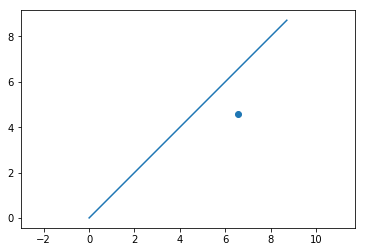

In [23]:
dion.plot.plot_diagram(dgms[goi])

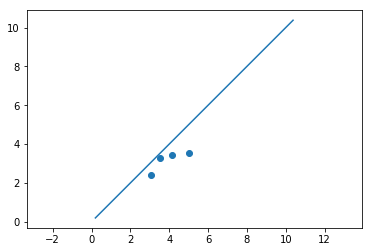

In [24]:
dion.plot.plot_diagram(adv_dgms[goi])

In [25]:
print(sample_graphs[goi].keys())

dict_keys([(2, 0, 37), (2, 0, 11), (2, 0, 29)])


In [26]:
print(adv_sample_graphs[goi].keys())

dict_keys([(2, 0, 37), (2, 0, 11), (2, 0, 20), (2, 0, 25), (2, 0, 2)])


In [27]:
lifetimes[goi]

{(2, 0, 37): 8.713050842285156,
 (2, 0, 11): 1.9580168724060059,
 (2, 0, 29): 4.29449987411499}

In [28]:
adv_lifetimes[goi]

{(2, 0, 37): 10.37637996673584,
 (2, 0, 11): 1.5020081996917725,
 (2, 0, 20): 0.6758878231048584,
 (2, 0, 25): 0.23544549942016602,
 (2, 0, 2): 0.6559453010559082}

In [ ]:
sgk = (2,0,13)
asgk = (2,0,31)

In [ ]:
# fig = plt.figure(figsize=(12, 12))
# draw_neural_net(fig.gca(), .1, .9, .1, .9, sample_graphs[goi][sgk], n_layers=4)

In [ ]:
options = {
    'node_color': 'red',
    'node_size': 2,
    'width': 2,
    'with_labels':True}
nx.draw_spring(sample_graphs[goi][sgk], **options)

In [ ]:
options = {
    'node_color': 'red',
    'node_size': 2,
    'width': 2,
    'with_labels':True}
nx.draw_spring(adv_sample_graphs[goi][asgk], **options)

In [ ]:
sample_graphs[goi][sgk].edges(data=True)

In [ ]:
adv_sample_graphs[goi][asgk].edges(data=True)

In [ ]:
def hamming_distance(g1, g2, ret_labels=False):
    nodeset = set(list(g1.nodes) + list(g2.nodes))
    g1_vec = np.zeros((len(nodeset)))
    g2_vec = np.zeros((len(nodeset)))
    nodesetlist = list(nodeset)
    for i in range(len(nodesetlist)):
        node = nodesetlist[i]
        if node in g1.nodes:
            g1_vec[i] = 1.0
        if node in g2.nodes:
            g2_vec[i] = 1.0
    if ret_labels:
        return hamming(g1_vec, g2_vec), nodesetlist
    else:
        return hamming(g1_vec, g2_vec)
    
def edge_hamming_distance(g1, g2, ret_labels=False):
    edgeset = set(list(g1.edges) + list(g2.edges))
    g1_vec = np.zeros((len(edgeset)))
    g2_vec = np.zeros((len(edgeset)))
    edgesetlist = list(edgeset)
    for i in range(len(edgesetlist)):
        edge = edgesetlist[i]
        if edge in g1.edges:
            g1_vec[i] = 1.0
        if edge in g2.edges:
            g2_vec[i] = 1.0
    if ret_labels:
        return hamming(g1_vec, g2_vec), edgesetlist
    else:
        return hamming(g1_vec, g2_vec)
    
def lifetime_weighted_edge_distance(subgraphs1,subgraphs2,lifetimes1,lifetimes2,ret_labels=False):
    edges1 = {}
    edges2 = {}
    sg1keys = list(subgraphs1.keys())
    sg2keys = list(subgraphs2.keys())
    lifetimes1 = list(lifetimes1.values())
    lifetimes2 = list(lifetimes2.values())
    ml1 = max(lifetimes1)
    ml2 = max(lifetimes2)
    for i in range(len(sg1keys)):
        g = subgraphs1[sg1keys[i]]
        for e in g.edges:
            edges1[e] = lifetimes1[i]/ml1
    for i in range(len(sg2keys)):
        g = subgraphs2[sg2keys[i]]
        for e in g.edges:
            edges2[e] = lifetimes2[i]/ml2
    edgeset = set(list(edges1.keys()) + list(edges2.keys()))
    g1_vec = np.zeros((len(edgeset)))
    g2_vec = np.zeros((len(edgeset)))
    edgesetlist = list(edgeset)
    for i in range(len(edgesetlist)):
        edge = edgesetlist[i]
        if edge in edges1:
            g1_vec[i] += edges1[edge]
        if edge in edges2:
            g2_vec[i] += edges2[edge]
    if ret_labels:
        return cosine(g1_vec, g2_vec), edgesetlist
    else:
        return cosine(g1_vec, g2_vec)
    
def weighted_edge_distance(g1, g2, ret_labels=False):
    edgeset = set(list(g1.edges) + list(g2.edges))
    g1_vec = np.zeros((len(edgeset)))
    g2_vec = np.zeros((len(edgeset)))
    edgesetlist = list(edgeset)
    for i in range(len(edgesetlist)):
        edge = edgesetlist[i]
        if edge in g1.edges:
            g1_vec[i] = g1[edge[0]][edge[1]]['weight']
        if edge in g2.edges:
            g2_vec[i] = g2[edge[0]][edge[1]]['weight']
    if ret_labels:
        return cosine(g1_vec, g2_vec), edgesetlist
    else:
        return cosine(g1_vec, g2_vec)
    
def total_edge_weights(graphs):
    emap = {}
    for g in graphs:
        for e in g.edges:
            if e in emap:
                emap[e] += g[e[0]][e[1]]['weight']
            else:
                emap[e] = g[e[0]][e[1]]['weight']
    return emap

def count_nodes(graphs):
    nmap = {}
    for g in graphs:
        for n in g.nodes:
            if n in nmap:
                nmap[n] += 1.0
            else:
                nm[2] = 1.0
    return nmap

In [ ]:
hamming_distance(sample_graphs[goi][sgk],adv_sample_graphs[goi][asgk])

In [ ]:
weighted_edge_distance(sample_graphs[goi][sgk],adv_sample_graphs[goi][asgk])

In [ ]:
adv_thru = -1
sim_mat = np.zeros((len(sample_graphs[goi]),len(adv_sample_graphs[goi])))
sk = list(sample_graphs[goi].keys())
ak = list(adv_sample_graphs[goi].keys())[:adv_thru]
for i in range(len(sk)):
    g = sample_graphs[goi][sk[i]]
    for j in range(len(ak)):
        ag = adv_sample_graphs[goi][ak[j]]
        sim_mat[i,j] = 1 - weighted_edge_distance(g,ag)
        

In [ ]:
# ax = sns.heatmap(sim_mat[~np.all(sim_mat == 0, axis=1)], linewidths=.01)
ax = sns.heatmap(sim_mat, linewidths=.01)
plt.yticks(rotation=0)
plt.ylabel('Unaltered Subgraphs')
plt.xlabel('Adversarial Subgraphs')
plt.savefig('/home/tgebhart/projects/pt_activation/logdir/vis/cff_mnist/heatmap.png', format='png', dpi=500)

In [ ]:
# gois = [sample_graphs[goi][k] for k in sample_graphs[goi].keys()]
# all_goi = nx.compose_all(gois)

In [ ]:
# adv_gois = [adv_sample_graphs[goi][k] for k in adv_sample_graphs[goi].keys()]
# adv_all_goi = nx.compose_all(adv_gois)

In [ ]:
# combs = []
# for sg in sample_graphs:
#     combs.append(nx.compose_all([sg[k] for k in sg.keys()]))
# adv_combs = []
# for sg in adv_sample_graphs:
#     adv_combs.append(nx.compose_all([sg[k] for k in sg.keys()]))

In [ ]:
sorted_res_df = res_df.sort_values(by=['prediction'])
sorted_res_df.head()

In [ ]:
# comb_sim_mat = np.zeros((len(combs),len(adv_combs)))
# for i in range(len(combs)):
#     g = combs[i]
#     for j in range(len(adv_combs)):
#         ag = adv_combs[j]
#         comb_sim_mat[i,j] = 1 - weighted_edge_distance(g,ag)

# comb_sim_mat = np.zeros((len(sample_graphs), len(adv_sample_graphs)))
# for i in range(len(sample_graphs)):
#     for j in range(len(adv_sample_graphs)):
#         comb_sim_mat[i,j] = 1 - lifetime_weighted_edge_distance(sample_graphs[i],adv_sample_graphs[j],lifetimes[i],adv_lifetimes[j])

comb_sim_mat = np.zeros((len(sample_graphs), len(sample_graphs)))
sidx = list(sorted_res_df.index)
for i in range(len(sample_graphs)):
    ix = sidx[i]
    for j in range(len(sample_graphs)):
        jx = sidx[j]
        comb_sim_mat[i,j] = 1 - lifetime_weighted_edge_distance(sample_graphs[ix],sample_graphs[jx],lifetimes[ix],lifetimes[jx])
        

In [ ]:
csmdf = pd.DataFrame(comb_sim_mat, columns=sorted_res_df['prediction'], index=sorted_res_df['prediction'])

In [ ]:
# ax = sns.heatmap(comb_sim_mat)
# plt.yticks(rotation=0)
# plt.ylabel('Unaltered Graphs')
# plt.xlabel('Adversarial Graphs')
# plt.savefig('comb_heatmap.png', format='png', dpi=500)

# ax = sns.heatmap(comb_sim_mat, xticklabels=sorted_res_df['prediction'],yticklabels=sorted_res_df['prediction'])
ax = sns.heatmap(csmdf, xticklabels=3, yticklabels=2)
plt.yticks(rotation=0)
plt.tick_params(axis='y',labelsize=5)
plt.tick_params(axis='x',labelsize=4)
plt.ylabel('Unaltered Graphs')
plt.xlabel('Unaltered Graphs')
plt.savefig('/home/tgebhart/projects/pt_activation/logdir/vis/cff_mnist/comb_heatmap_no_adv.png', format='png', dpi=500)

In [ ]:
comb_sim_mat2 = np.zeros((len(sample_graphs), len(sample_graphs)))
for i in range(len(sample_graphs)):
    for j in range(len(sample_graphs)):
        comb_sim_mat2[i,j] = 1 - lifetime_weighted_edge_distance(sample_graphs[i],sample_graphs[j],lifetimes[i],lifetimes[j])
    

In [ ]:
ngoi = 2
res_df.iloc[ngoi].head()

In [ ]:
res_df.iloc[comb_sim_mat2[ngoi,:].argsort()[-10:][::-1]]

In [ ]:
res_df.iloc[comb_sim_mat2[0,:].argsort()[-10:][::-1]]